# Final Lab

In [1]:
import pandas as pd
import numpy as np

# EDA

I first did a log transform on the target variable because it was extremely right skewed. You can see that the resulting transform looks far more normally distributed and should be easier to work with using regression models.

First I trained a linear regression model using a scaled and standardized x so that we could see what elements were probably the most important based off of coefficients. If we don't standardize and scale the features then the coefficients become a lot harder to compare because a small coefficient may actually be a very important if the feature is on a very large scale. I removed insignificant variables iteratively based off of the p-values. Finally, I chose to keep elements that had an absolute coefficient of at least 0.01. 

Next I trained a decision tree regressor also using scaled and standardized x. I did a grid search over several cpp_alpha values to prune features and improve our tree. We actually see a significant improvement in both R^2 and mean_squared_error metrics between the tuned tree and the initial vanilla tree (-0.8 to 0.09 R^2 and 1.57 to 0.78 MSE). This was not the case with the linear regression model. After tuning the tree, I used feature importance rankings to sort features from the most important to least important. 

I chose the top 5 absolutely largest coefficients from linear regression and decision tree to plot against the target variable. When plotting against the target variable, if the feature is binary, I used a box and whisker plot, and I used a scatterplot if the feature was continuous.

The top 5 predictors based on absolute coefficients from the linear regression model were: LDA_0, LDA_1, ... LDA_4. The top 5 predictors based on the feature importance scores from the decision tree were: N_unique_tokens, data_channel_is_entertainment, data_channel_is_socmed, data_channel_is_tech, and kw_max_max.

<Axes: >

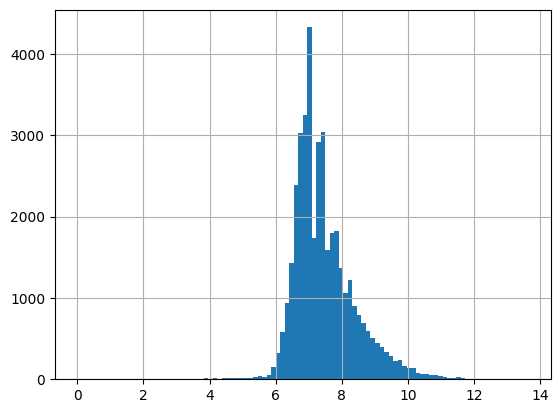

In [7]:
dataset = pd.read_csv('https://richardson.byu.edu/220/OnlineNewsPopularity.csv')
shares = dataset[' shares']
logged_y = shares.apply(lambda x: 0 if x == 0 else np.log(x))
logged_y.hist(bins=100)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

X = dataset.drop(['url', ' timedelta', ' shares'], axis=1)
x_scaler = StandardScaler()
x_scaler.fit_transform(X)
X_scaled = x_scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, logged_y, test_size=0.2)

model = LinearRegression()
model.fit(X_train, y_train)
print("Initial R^2: ", model.score(X_test, y_test))
print("Initial MSE: ", mean_squared_error(y_test, model.predict(X_test)))
# iterate over the p scores and remove them one at a time until the p score is less than 0.05
import statsmodels.api as sm
X_train = sm.add_constant(X_train)
p_values = sm.OLS(y_train, X_train).fit().pvalues
p_values = p_values.drop('const')
while p_values.max() >= 0.05:
    print("dropping: ", p_values.idxmax())
    X_train = X_train.drop(p_values.idxmax(), axis=1)
    X_test = X_test.drop(p_values.idxmax(), axis=1)
    model.fit(X_train, y_train)
    p_values = sm.OLS(y_train, X_train).fit().pvalues
    p_values = p_values.drop('const')



X_test = sm.add_constant(X_test)

print("Final score: ", model.score(X_test, y_test))
print("Final MSE: ", mean_squared_error(y_test, model.predict(X_test)))
# print the model coefficients next to the column names
coefficients = pd.Series(model.coef_, index=X_train.columns)
# sort the coefficients from absolute largest to smallest
coefficients = coefficients.reindex(coefficients.abs().sort_values(ascending=False).index)
# keep only the coefficients absolutely greater than 0.01
coefficients = coefficients[coefficients.abs() > 0.01]
print(coefficients)
print(len(coefficients))

Initial R^2:  0.13623038561369227
Initial MSE:  0.7653428663096413
dropping:   abs_title_sentiment_polarity
dropping:   global_rate_negative_words
dropping:   max_negative_polarity
dropping:   rate_negative_words
dropping:   global_sentiment_polarity
dropping:   max_positive_polarity
dropping:   self_reference_max_shares
dropping:   kw_max_max
dropping:   min_negative_polarity
dropping:   avg_positive_polarity
dropping:   n_unique_tokens
dropping:   rate_positive_words
dropping:   n_tokens_content
dropping:   data_channel_is_world
dropping:   self_reference_min_shares
dropping:   weekday_is_monday
dropping:   weekday_is_friday
Final score:  0.13595718660651623
Final MSE:  0.7655849342265287
LDA_03                           82.414137
LDA_04                           80.761778
LDA_02                           78.727961
LDA_00                           73.507463
LDA_01                           61.336127
n_non_stop_words                  1.934774
n_non_stop_unique_tokens         -0.523451

In [4]:
from sklearn.tree import DecisionTreeRegressor
# figure out which cpp_alpha to use
from sklearn.model_selection import GridSearchCV

parameters = {'ccp_alpha': [0.001, 0.01, 0.1, 1, 10]}
tree = DecisionTreeRegressor()
model = GridSearchCV(tree, parameters)
X_tree_train, X_tree_test, y_tree_train, y_tree_test = train_test_split(X_scaled, logged_y, test_size=0.2)
model.fit(X_tree_train, y_tree_train)

initial_model = DecisionTreeRegressor()
initial_model.fit(X_tree_train, y_tree_train)
print("initial score: ", initial_model.score(X_tree_test, y_tree_test))
print("initial mse: ", mean_squared_error(y_tree_test, initial_model.predict(X_tree_test)))
print(model.best_params_)
print("Final score: ", model.score(X_tree_test, y_tree_test))
print("Final mse: ", mean_squared_error(y_tree_test, model.predict(X_tree_test)))
# print the feature importances
model = DecisionTreeRegressor(ccp_alpha=0.001) # 0.001 was the best ccp_alpha
model.fit(X_tree_train, y_tree_train)
importances = pd.Series(model.feature_importances_, index=X_tree_train.columns)
importances = importances[importances > 0.01]
print(importances)
print(len(importances))


initial score:  -0.8096616032211079
initial mse:  1.574557530473957
{'ccp_alpha': 0.001}
Final score:  0.09624422370298058
Final mse:  0.7863434029571671
n_tokens_content                 0.011409
n_unique_tokens                  0.010177
data_channel_is_entertainment    0.027994
data_channel_is_socmed           0.013585
data_channel_is_tech             0.027792
kw_max_min                       0.011725
kw_min_max                       0.013277
kw_max_max                       0.049314
kw_max_avg                       0.062046
kw_avg_avg                       0.521304
self_reference_min_shares        0.094151
self_reference_avg_sharess       0.104852
is_weekend                       0.052376
dtype: float64
13


Decision Tree


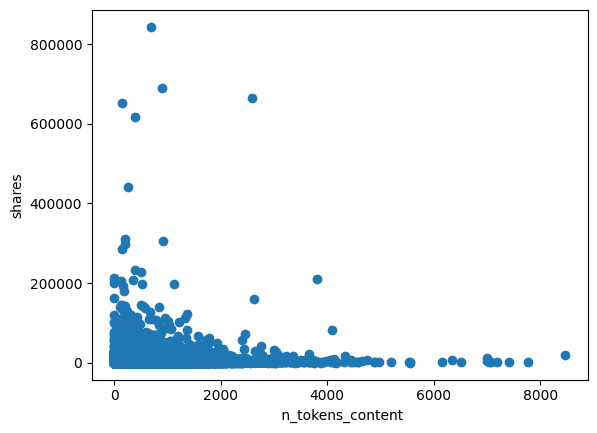

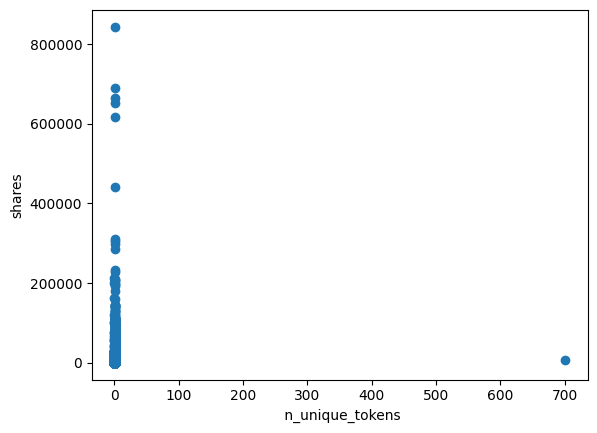

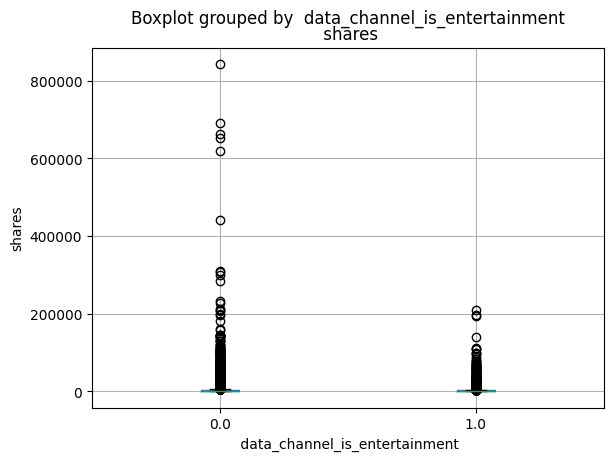

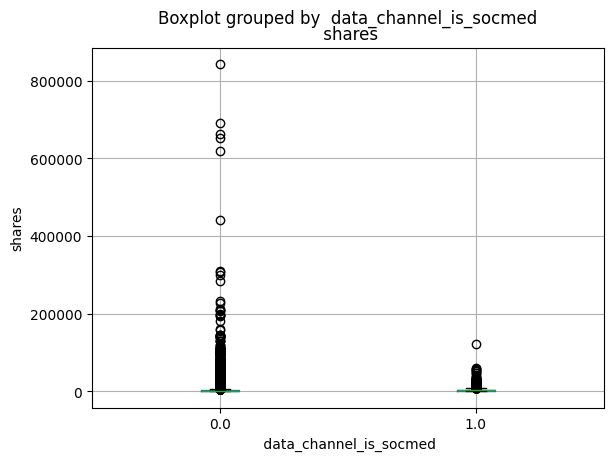

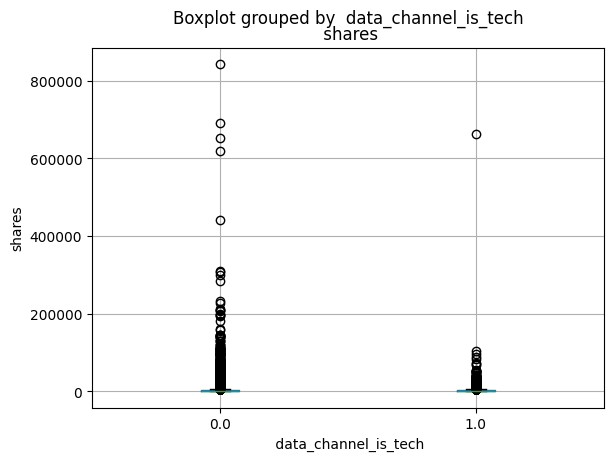

Linear Regression


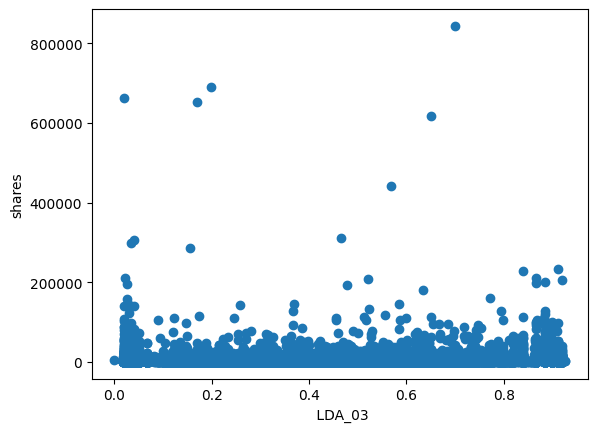

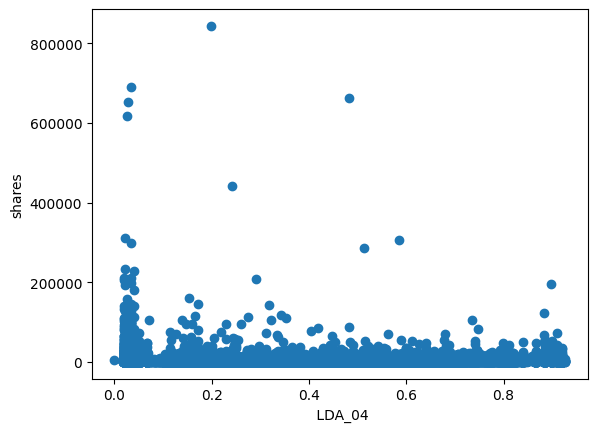

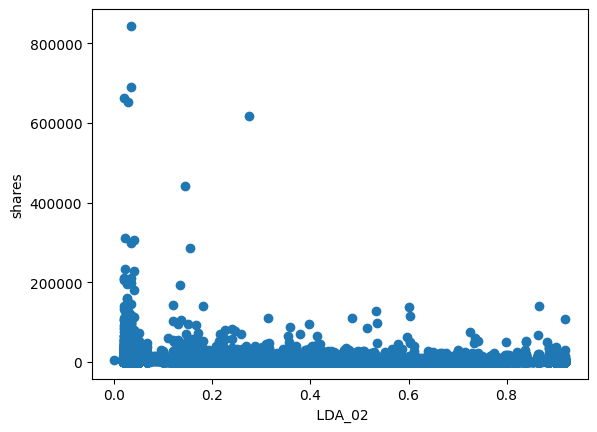

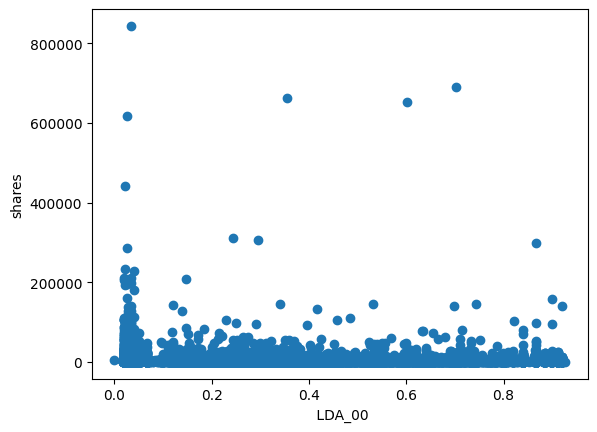

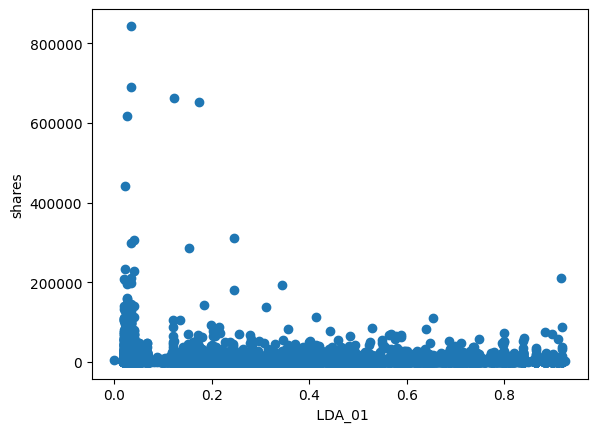

In [9]:
#pick the top 5 features from the linear regression and decision tree models. Then plot them against the target variable.
import matplotlib.pyplot as plt
top_features = importances.index[:5]
print('Decision Tree')
for feature in top_features:
    # if the only values are 0 or 1 plot a boxplot
    if len(X[feature].unique()) == 2:
        dataset.boxplot(column=' shares', by=feature)
    else:
        plt.scatter(X[feature], shares)
    plt.xlabel(feature)
    plt.ylabel('shares')
    plt.show()
print('Linear Regression')
#pick the top 5 features from the linear regression and decision tree models. Then plot
# them against the target variable.
top_features = coefficients.index[:5]
for feature in top_features:
    if len(X[feature].unique()) == 2:
        dataset.boxplot(column=' shares', by=feature)
    else:
        plt.scatter(X[feature], shares)
    plt.xlabel(feature)
    plt.ylabel('shares')
    plt.show()

# Linear Regression Modeling

In [10]:
from sklearn.linear_model import LassoCV

shares = dataset[' shares']
logged_y = shares.apply(lambda x: 0 if x == 0 else np.log(x))
X = dataset.drop(['url', ' timedelta', ' shares'], axis=1)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, logged_y, test_size=0.2, random_state=42)

# LASSO regression
lasso_model = LassoCV(alphas=np.logspace(-4, 1, 50), cv=5, random_state=42, max_iter=10000)
lasso_model.fit(X_train, y_train)

# Evaluate LASSO model
lasso_predictions = lasso_model.predict(X_test)
lasso_r2 = r2_score(y_test, lasso_predictions)
lasso_mse = mean_squared_error(y_test, lasso_predictions)

# Extract significant features
lasso_coefficients = pd.Series(lasso_model.coef_, index=X_train.columns)
significant_features = lasso_coefficients[lasso_coefficients != 0]

#### LASSO Regression Results
print(f"Best alpha (α): {lasso_model.alpha_:.5f}")
print(f"Out-of-sample R²: {lasso_r2:.5f}")
print(f"Out-of-sample MSE: {lasso_mse:.5f}")
print(f"Number of significant predictors: {len(significant_features)}")

#### Most Significant Predictors (LASSO)
{significant_features.sort_values(ascending=False).to_string()}

c:\Users\BYU Rental\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.908307039961073, tolerance: 2.203475511182072
  model = cd_fast.enet_coordinate_descent_gram(


Best alpha (α): 0.00041
Out-of-sample R²: 0.12752
Out-of-sample MSE: 0.74882
Number of significant predictors: 52


{'kw_avg_avg                       0.415565\nis_weekend                       0.092832\nLDA_00                           0.081502\nkw_min_min                       0.059993\nglobal_subjectivity              0.050752\nkw_max_min                       0.050556\ndata_channel_is_tech             0.048598\nnum_hrefs                        0.048037\ndata_channel_is_socmed           0.045381\nLDA_04                           0.033828\nself_reference_avg_sharess       0.029634\nabs_title_subjectivity           0.029314\nrate_positive_words              0.029125\nnum_imgs                         0.028733\nself_reference_min_shares        0.027470\nweekday_is_friday                0.026425\nnum_keywords                     0.024260\nweekday_is_monday                0.023956\ntitle_subjectivity               0.022309\nn_tokens_content                 0.021905\ntitle_sentiment_polarity         0.019145\nn_tokens_title                   0.018207\nnum_videos                       0.009962\nabs_title

## Model Results

Out-of-Sample Performance:
The LASSO regression model was tuned using cross-validation to optimize the regularization parameter, 
𝛼. The best α value obtained was 0.00041, which balances model complexity and predictive performance.

Out-of-sample 𝑅^2: 0.12752
Out-of-sample MSE: 0.74882
Number of Significant Predictors: 52
These metrics indicate that the model captures some of the variance in the number of shares but leaves a significant portion unexplained, suggesting that the model has limited predictive power. The relatively low R^2 value highlights the challenges in predicting shares, which may be influenced by factors not included in the dataset.

Significant Predictors:
The LASSO regression identified 52 predictors as significant. Below are the most impactful variables, sorted by their absolute coefficient values:

kw_avg_avg (0.4156): This feature, representing the average keyword score, had the highest positive influence on shares. It suggests that the quality of keywords is a strong driver of article popularity.
is_weekend (0.0928): Articles published on weekends tend to receive more shares, indicating timing is an essential factor in content sharing.
LDA_00 (0.0815): Topic modeling feature 0, likely capturing a specific thematic focus, positively influenced shares.
kw_min_min (0.0600): The minimum keyword score also played a positive role, suggesting a broad keyword range might contribute to higher shares.
global_subjectivity (0.0508): Articles with higher subjectivity levels appeared to attract more shares, indicating that emotional or opinion-driven content resonates with readers.

Negative predictors included:
kw_max_avg (-0.2378): Articles with a high maximum average keyword score negatively influenced shares, potentially due to over-optimization of keywords.
data_channel_is_entertainment (-0.0651): Content in the entertainment category showed a negative association with shares, which may indicate a saturation of such content.
average_token_length (-0.0584): Longer average word lengths were associated with fewer shares, possibly due to reduced readability.
Model Usefulness for Predicting Future Shares
While the model identifies key predictors of article shares, its R^2 value of 0.12752 suggests it explains only a small portion of the variance. The high number of significant predictors indicates a complex relationship between features and shares, but the overall predictive power remains modest.

This model is useful for gaining insights into factors that influence article popularity. For example, optimizing keyword quality (kw_avg_avg) and strategically timing article publication (is_weekend) can improve shares. However, its ability to precisely predict future shares is limited, and additional data or alternative modeling techniques might be necessary for better performance.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor


r_state = 12
parameters = {'ccp_alpha': np.linspace(0, 0.005, 10)}
tree_model = DecisionTreeRegressor(random_state=r_state)
tree_grid = GridSearchCV(tree_model, parameters, cv=3, n_jobs=-1) # njobs allows all cores to run because my pc running so slowly
tree_grid.fit(X_train, y_train) #use training data from before

print("Best ccp_alpha:", tree_grid.best_params_)
print("Best tree R^2:", tree_grid.best_score_)
print("Test R^2:", tree_grid.score(X_test, y_test))

best_tree_model = tree_grid.best_estimator_

randforest_model = RandomForestRegressor(ccp_alpha=0.001, random_state=r_state)
randforest_model.fit(X_train, y_train)

print("Random Forest R^2:", randforest_model.score(X_test, y_test))
print(f"Decision Tree MSE: {mean_squared_error(y_test, best_tree_model.predict(X_test))}")
print(f"Random Forest MSE: {mean_squared_error(y_test, randforest_model.predict(X_test))}")

Best ccp_alpha: {'ccp_alpha': 0.0011111111111111111}
Best tree R^2: 0.09933269826216133
Test R^2: 0.12003478778248777
Random Forest R^2: 0.1427316332654307
Decision Tree MSE: 0.755248165617703
Random Forest MSE: 0.7357681331365281


### Write a section in your technical report that reports the out-of-sample performance of the models. Discuss the model’s usefulness for predicting future shares

The out of sample performance of the models came out to be the following:

Decision Tree:
- R^2 Test: ~0.1200 — The gist of this statistic is that the model explains only ~12% of the variance in the test data
- MSE Test: ~0.7552 — The models mse on the test set. This was higher than the random forest mse, meaning that this model has a lower prediction accuracy.

Random Forest:
- R^2 Test: ~0.1427 — The gist of this statistic is that the model explains a measly ~14% of the variance in the test data.
- MSE Test: ~0.7358 — The mse on the test set, which is lower than the Decision Trees mse, meaning that it had a better prediction accuracy.

The Random Forest does seem to do better than the Decision Tree, but because both of the models R^2 values seem to be pretty low, we really cant use them for prediction of the usefulness of future shares. I would highly recommend adding more predictive variables, since that would allow the model to further hone its ability to predict future shares. I would say that this model gives less of an accurate prediction, and instead gives a vague idea on what might happen in the future. For stakeholders, I would probably not use this as the only decision on whether or not you purchase shares, but it also cannot just be brushed off since everything here was done with math and calculations. Stakholders should consider their own domain of knowlege and consider the limitations put in place by this model.
